In [1]:
#General Imports
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random as rnd
from time import perf_counter as time
import numpy as np

In [2]:
dataset_fpath = './data/BTS1_BTS2_fields_preserved.zip'
nidd_dataset = pd.read_csv(dataset_fpath, compression = 'zip', low_memory=False)

#Attack Type for Multi-Class Classification or Label for Binary Classification
TARGET = 'Label'
DROPPED_TARGET = "Label" if TARGET == "Attack Type" else "Attack Type"

useless_features = ['Attack Tool', DROPPED_TARGET, 'Dport', 'Sport', 'SrcAddr', 'DstAddr',"Unnamed: 0"]
nidd_dataset = nidd_dataset.drop(useless_features, axis=1)
print(f"Original shape of data: {nidd_dataset.shape}")

Original shape of data: (1215890, 106)


### Dropping Features with the following properties:
    - Having NaN values above 95% of their total values
    - Having Zero values above 95% of their total values
    - Having constant values 

In [3]:
features_dropped = {"Nan columns": [], "Zero columns": [], "Constant columns": [], "General columns": useless_features}
preprocessing_d = {"Time <Dropping features based on a threshold `bad` values>": 0.,
                   "Filling NaNs": 0.,
                   "Time <Encoding categorical features>": 0.,
                   "Time <Feature selection>": 0.}


t0 = time()

threshold_nans = 0.95 * nidd_dataset.shape[0]
columns_Nan_to_drop = nidd_dataset.columns[nidd_dataset.isna().sum() > threshold_nans]
features_dropped["Nan columns"].extend(columns_Nan_to_drop)
nidd_dataset_cleaned_nan  = nidd_dataset.drop(columns=columns_Nan_to_drop)
# eq nidd_dataset_cleaned_nan = nidd_dataset.dropna(thresh = ceil(1 - threshold_nans = 0.95 * nidd_dataset.shape[0]), axis = 1)
print(f"After dropping NaN columns: {nidd_dataset_cleaned_nan.shape}")

threshold_zeros = 0.95 * nidd_dataset.shape[0]
zero_counts = nidd_dataset_cleaned_nan.apply(lambda col: (col == 0).sum())
columns_zeros_to_drop = zero_counts[zero_counts > threshold_zeros].index
features_dropped["Zero columns"].extend(columns_zeros_to_drop)
nidd_dataset_cleaned_zeros = nidd_dataset_cleaned_nan.drop(columns_zeros_to_drop, axis=1)
print(f"After dropping NaN & Zero columns: {nidd_dataset_cleaned_zeros.shape}")

constant_columns = nidd_dataset_cleaned_zeros.columns[nidd_dataset_cleaned_zeros.nunique() == 1]
features_dropped["Constant columns"].extend(constant_columns)
nidd_dataset_cleaned = nidd_dataset_cleaned_zeros.drop(columns=constant_columns)
print(f"After dropping NaN & Zero & Constant columns: {nidd_dataset_cleaned.shape}")

t1 = time()


preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = t1 - t0

After dropping NaN columns: (1215890, 70)
After dropping NaN & Zero columns: (1215890, 55)
After dropping NaN & Zero & Constant columns: (1215890, 51)


### Replacing NaN values & label encoding categorical features:
    - Numerical features with their mean
    - Categorical features with the most frequent category


In [4]:
# Getting columns out of their respective dtypes (numeric and categorical)

t0 = time()

numeric_cols = nidd_dataset_cleaned.select_dtypes(include='number').columns
categorical_cols = nidd_dataset_cleaned.select_dtypes(include='object').columns
numeric_cols_mean = nidd_dataset_cleaned[numeric_cols].mean()
nidd_dataset_cleaned[numeric_cols] = nidd_dataset_cleaned[numeric_cols].fillna(numeric_cols_mean)

#iloc[0] is used to get the first element of the series in case there is more than one category that produces 
# the same mode.
categorical_cols_mode = nidd_dataset_cleaned[categorical_cols].mode().iloc[0]
nidd_dataset_cleaned[categorical_cols] = nidd_dataset_cleaned[categorical_cols].fillna(categorical_cols_mode)

t1 = time()


preprocessing_d["Time <Filling NaNs>"] = t1 - t0


t0 = time()
# Encoding categorical columns
label_encoder = LabelEncoder()
for column in categorical_cols:
    nidd_dataset_cleaned[column] = label_encoder.fit_transform(nidd_dataset_cleaned[column])

t1 = time()
preprocessing_d["Time <Encoding categorical features>"] = t1 - t0

### Calculating the Pearson Correlation matrix and plotting its Heatmap
    We find the pairwise corellation for every single pair of features. We also consider absolute values
    so as to include high negative correlation as well. Based on a threshold(0.9 here) we remove one feature
    from each pair(the one having the lowest correlation )

Final shape of cleaned DataFrame after removing correlated features based on Pearson method: (1215890, 36)


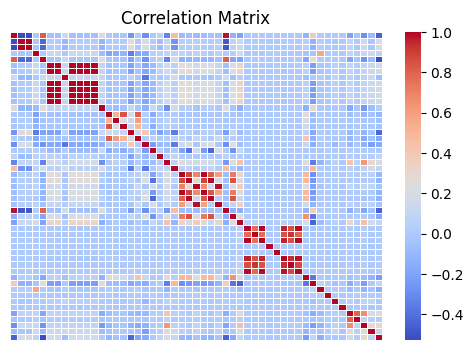

In [5]:
t0 = time()

target_col = nidd_dataset_cleaned.columns[-1]
correlation_matrix = nidd_dataset_cleaned.corr(method = 'pearson')
corr_threshold = 0.9
# high_corr_pairs = (correlation_matrix.abs() > corr_threshold) & (correlation_matrix.abs() < 1)
high_corr_pairs = correlation_matrix.iloc[:,:-1].abs() > corr_threshold
# print(high_corr_pairs)
features_to_drop = set() # avoid duplicate entries

for feature_on_col in high_corr_pairs.columns:
    for feature_in_row in high_corr_pairs.index[high_corr_pairs[feature_on_col]]:
        if feature_on_col != feature_in_row:  # avoid comparisons between same pairs
            # getting the correlation values for each feature against target variable
            feature_in_row_cor_val = correlation_matrix.loc[feature_in_row, target_col]
            feature_on_col_cor_val = correlation_matrix.loc[feature_on_col, target_col]
            
            same_corellation_sign = feature_in_row_cor_val * feature_on_col_cor_val > 0
            
            if same_corellation_sign:
                if abs(feature_in_row_cor_val) > abs(feature_on_col_cor_val):
                    features_to_drop.add(feature_on_col)
                else:
                    features_to_drop.add(feature_in_row)


nidd_dataset_filtered = nidd_dataset_cleaned.drop(columns=list(features_to_drop))
t1 = time()
print(f"Final shape of cleaned DataFrame after removing correlated features based on Pearson method: {nidd_dataset_filtered.shape}")

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', 
            fmt='.2f', xticklabels=False, yticklabels=False,
            linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### Using Anova F-test to calculate a score that quantifies changes in mean and variance against the target variable

In [6]:
X = nidd_dataset_filtered.drop(columns=[target_col])
y = nidd_dataset_filtered[target_col]

t2 = time()
f_scores, _ = f_classif(X, y)
results_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores})
results_df = results_df.sort_values(by='F-Score', ascending=False)
t3 = time()
preprocessing_d["Time <Feature selection>"] = t1-t0 + t3-t2

top_10_features = results_df.head(10)
print("Top 10 Features based on ANOVA F-scores")
for index, row in top_10_features.iterrows():
    print(f"{row['Feature']}: {row['F-Score']}")

Top 10 Features based on ANOVA F-scores
Seq: 469849.6390666038
Offset: 319314.40971959295
sTtl: 271902.447512305
AckDat: 114843.30885848559
Dir: 67629.15152188136
StartTime: 54826.22943189787
dIpId: 53749.31118614725
TcpRtt: 48169.83238437568
dTtl: 40155.94625566492
sMeanPktSz: 38473.44797186211


### Applying Z-normalization to the selected features, training a RandomForest classifier

In [7]:

top_10_features_cols = top_10_features['Feature'].tolist()
target = nidd_dataset_filtered[TARGET]
features = nidd_dataset_filtered[top_10_features_cols]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=rnd.seed(42)) 

numeric_features = list(set(numeric_cols) & set(top_10_features_cols))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)


### Plotting Confusion Matrix and classification report

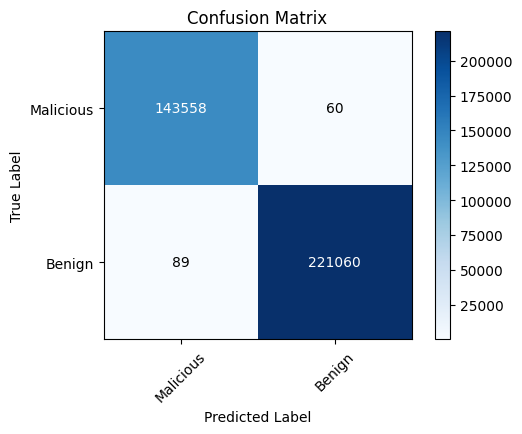

Classification Report:
               precision    recall  f1-score   support

   Malicious   0.999380  0.999582  0.999481    143618
      Benign   0.999729  0.999598  0.999663    221149

    accuracy                       0.999592    364767
   macro avg   0.999555  0.999590  0.999572    364767
weighted avg   0.999592  0.999592  0.999592    364767

Time <Dropping features based on a threshold `bad` values>: 2.6708 seconds
Filling NaNs: 0.0000 seconds
Time <Encoding categorical features>: 1.7321 seconds
Time <Feature selection>: 5.3172 seconds
Time <Filling NaNs>: 2.1259 seconds


In [8]:
conf_matrix = confusion_matrix(y_test, predictions)

target_categories = set(nidd_dataset[TARGET])

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(target_categories)), labels=target_categories, rotation=45)
plt.yticks(ticks=np.arange(len(target_categories)), labels=target_categories)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

class_report = classification_report(y_test, predictions, target_names=target_categories , digits=6)
print("Classification Report:\n", class_report)
for key, time in preprocessing_d.items():
    print(f"{key}: {time:.4f} seconds")
